# Step1： 设置基本参数

In [3]:
import os
from dotenv import load_dotenv
ROOT_DIR= os.path.dirname(os.getcwd())
print(ROOT_DIR)
# 加载环境变量
load_dotenv()
# 从环境变量中读取api_key
api_key = os.getenv('ZISHU_API_KEY')
print(api_key)
base_url = "http://101.132.164.17:8000/v1"
chat_model = "glm-4-flash"
emb_model = "embedding-3"

c:\Users\zata\Desktop\wow\01-wow-agent
sk-CheAFXpUwl7euofb660f9269E3Af4609BdFfF426E57d46A5


# pydantic介绍

# Step2：测试接口

## 一些使用的解释
### 1. 修饰函数的概念
如@llm_completion_callback() 这是一个修饰函数修饰函数。
什么是装饰器函数呢？

装饰器函数是一种在 Python 中非常有用的设计模式，它允许你在不修改原函数代码的情况下，给函数添加额外的功能。

下面通过一个简单的例子来解释装饰器的概念。

> 假设我们有一个函数 `add`，用于计算两个数的和。现在我们希望在调用这个函数时，能够自动记录它的执行时间，而不需要修改 `add` 函数本身的代码。

`步骤 1: 定义原始函数`
```python
def add(a, b):
    return a + b
```

`步骤 2: 定义装饰器函数`
装饰器本质上是一个接受函数作为参数，并返回一个新的函数的高阶函数。

```python
import time

def timer_decorator(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()  # 记录开始时间
        result = func(*args, **kwargs)  # 调用原始函数
        end_time = time.time()  # 记录结束时间
        print(f"函数 {func.__name__} 执行时间: {end_time - start_time:.4f} 秒")
        return result
    return wrapper
```

`步骤 3: 使用装饰器`
我们可以通过 `@` 符号将装饰器应用到 `add` 函数上：

```python
@timer_decorator
def add(a, b):
    return a + b
```

等价于：
```python
def add(a, b):
    return a + b

add = timer_decorator(add)
```

`步骤 4: 测试装饰器`
调用 `add` 函数时，会自动打印出它的执行时间。

```python
result = add(3, 5)
print("结果:", result)
```

`输出示例：`
```
函数 add 执行时间: 0.0001 秒
结果: 8
```

---
好了，经过上面的例子你可能已经简单了解啥是装饰函数了，那我们先看一下下面的函数，然后再回到这里

```
from llama_index.core.llms.callbacks import llm_completion_callback
@llm_completion_callback()
def complete(self, prompt: str, **kwargs: Any) -> CompletionResponse:
    # 调用OpenAI API生成文本
    response = self.client.chat.completions.create(model=self.model_name, messages=[{"role": "user", "content": prompt}])
    # 检查响应中是否有choices字段，并提取生成的文本
    if hasattr(response, 'choices') and len(response.choices) > 0:
        response_text = response.choices[0].message.content
        return CompletionResponse(text=response_text)  # 返回生成的文本
    else:
        raise Exception(f"Unexpected response format: {response}")  # 如果响应格式不符合预期，抛出异常
```

我们进入到llama_index的源码中，看看这个函数

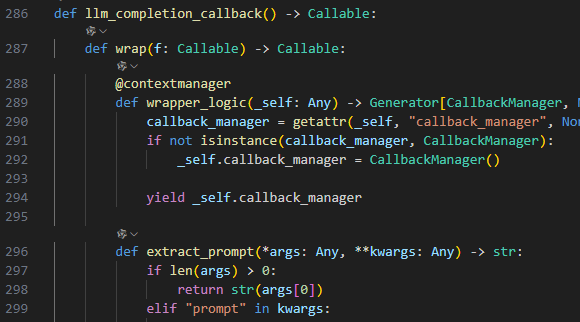

是不是很奇怪，因为没有传入参数啊，但是别着急，我们折叠一下代码

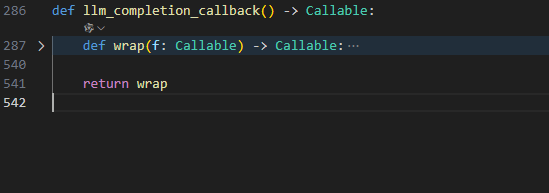

所以实际上wrap才是真正的装饰函数的定义,再接着往下看

我们看见还有一个 `@property`的装饰器，不过这个装饰器类是一个内置类，我们不用太过深究,它的主要目的是用于将方法伪装成属性。



In [12]:
from openai import OpenAI
from pydantic import Field  # 导入Field，用于Pydantic模型中定义字段的元数据
from llama_index.core.llms import (
    CustomLLM,
    CompletionResponse,
    LLMMetadata,
)
from llama_index.core.embeddings import BaseEmbedding
from llama_index.core.llms.callbacks import llm_completion_callback
from typing import List, Any, Generator

# 定义OurLLM类，继承自CustomLLM基类
class OurLLM(CustomLLM):
    # 定义类属性，使用Field为Pydantic模型字段添加元数据
    api_key: str = Field(default=api_key)  # OpenAI API密钥
    base_url: str = Field(default=base_url)  # OpenAI API的基础URL
    model_name: str = Field(default=chat_model)  # 使用的模型名称
    client: OpenAI = Field(default=None, exclude=True)  # OpenAI客户端实例，exclude=True表示不包含在序列化中

    # 初始化方法，接收api_key、base_url、model_name等参数
    def __init__(self, api_key: str, base_url: str, model_name: str = chat_model, **data: Any):
        super().__init__(**data)  # 调用父类的初始化方法
        self.api_key = api_key  # 设置api_key
        self.base_url = base_url  # 设置base_url
        self.model_name = model_name  # 设置model_name
        self.client = OpenAI(api_key=self.api_key, base_url=self.base_url)  # 初始化OpenAI客户端

    # 定义metadata属性，返回LLM的元数据
    # 这里的property 装饰器表示这是一个只读属性，不能修改
    @property
    def metadata(self) -> LLMMetadata:
        """Get LLM metadata."""
        return LLMMetadata(
            model_name=self.model_name,  # 返回模型名称
        )

    # 实现complete方法，用于处理同步的文本生成请求
    @llm_completion_callback()
    def complete(self, prompt: str, **kwargs: Any) -> CompletionResponse:
        # 调用OpenAI API生成文本
        response = self.client.chat.completions.create(model=self.model_name, messages=[{"role": "user", "content": prompt}])
        print(response)
        # 检查响应中是否有choices字段，并提取生成的文本
        if hasattr(response, 'choices') and len(response.choices) > 0:
            response_text = response.choices[0].message.content
            return CompletionResponse(text=response_text)  # 返回生成的文本
        else:
            raise Exception(f"Unexpected response format: {response}")  # 如果响应格式不符合预期，抛出异常

    # 实现stream_complete方法，用于处理流式文本生成请求
    @llm_completion_callback()
    def stream_complete(self, prompt: str, **kwargs: Any) -> Generator[CompletionResponse, None, None]:
        # 调用OpenAI API进行流式文本生成
        response = self.client.chat.completions.create(
            model=self.model_name,
            messages=[{"role": "user", "content": prompt}],
            stream=True # 定义stream=True，以启用流式响应
        )
        print(response)

        try:
            # 遍历流式响应的每个chunk，提取生成的文本
            for chunk in response:
                chunk_message = chunk.choices[0].delta
                if not chunk_message.content:  # 如果chunk中没有内容，跳过
                    continue
                content = chunk_message.content
                yield CompletionResponse(text=content, delta=content)  # 返回生成的文本和增量内容

        except Exception as e:
            raise Exception(f"Unexpected response format: {e}")  # 如果发生异常，抛出异常

# 创建OurLLM的实例，传入api_key、base_url

注意看上面的代码，不知道你有没有疑惑：上面实现了两种文本处理请求，一种是用于处理同步的文本生成请求，一种是用于处理流式的文本生成请求。它们之间的区别是什么?

这两个函数 `complete` 和 `stream_complete` 的主要区别在于它们处理文本生成的方式不同：一个是**同步的**，另一个是**流式的**。下面详细解释这两种方式的区别以及它们各自的应用场景。

---

### **1. 同步的文本生成 (`complete` 方法)**

#### **特点**
- **一次性返回结果**：`complete` 方法会等待整个文本生成过程完成，然后一次性返回生成的完整文本。
- **阻塞式操作**：在调用 `complete` 时，程序会一直等待，直到 API 返回完整的响应。在此期间，调用方无法获取任何中间结果。
- **适合简单任务**：适用于需要完整生成内容后再进行后续处理的场景，例如生成一段完整的回答、翻译一段文字等。

#### **代码逻辑**
1. 调用 OpenAI API，传入用户输入的 `prompt`。
2. 等待 API 返回完整的响应（即 `response` 对象）。
3. 检查响应中是否有 `choices` 字段，并提取生成的文本。
4. 如果响应格式正确，返回生成的文本；否则抛出异常。

#### **示例**
假设用户输入 `prompt = "What is AI?"`，`complete` 方法会等待模型生成完整的回答（例如 `"AI is a field of computer science..."`），然后将整个回答返回给调用方。

---

### **2. 流式的文本生成 (`stream_complete` 方法)**

#### **特点**
- **逐步返回结果**：`stream_complete` 方法会以“流”的形式逐步返回生成的文本，每次返回一小部分（称为一个“chunk”或“增量”）。
- **非阻塞式操作**：调用方可以在生成过程中实时获取部分结果，而不需要等待整个生成过程完成。
- **适合实时交互**：适用于需要实时展示生成内容的场景，例如聊天机器人、实时字幕生成、语音转文字等。

#### **代码逻辑**
1. 调用 OpenAI API，传入用户输入的 `prompt`，并设置 `stream=True` 参数以启用流式响应。
2. 遍历 API 返回的每个“chunk”，提取其中的内容。
3. 如果某个 chunk 中有内容，则将其作为增量返回给调用方。
4. 如果发生异常或响应格式不符合预期，抛出异常。

#### **示例**
假设用户输入 `prompt = "What is AI?"`，`stream_complete` 方法会逐步返回生成的文本，例如：
- 第一个 chunk：`"AI"`
- 第二个 chunk：`" is"`
- 第三个 chunk：`" a"`
- 第四个 chunk：`" field"`
- ...

调用方可以实时显示这些部分结果，从而提升用户体验。

---

### **同步 vs 流式：核心区别**

| 特性                  | 同步 (`complete`)                          | 流式 (`stream_complete`)                     |
|-----------------------|--------------------------------------------|---------------------------------------------|
| **返回方式**          | 一次性返回完整结果                        | 逐步返回部分结果                            |
| **阻塞性**            | 阻塞式，需等待生成完成                    | 非阻塞式，可实时获取部分结果                |
| **适用场景**          | 需要完整结果后再处理                      | 需要实时展示生成内容                       |
| **API 参数**          | 默认行为                                  | 需设置 `stream=True`                        |
| **性能**              | 可能延迟较高                              | 延迟较低，但可能增加网络开销               |

---

### **什么是流式？**

流式是一种数据传输方式，特点是数据以小块（chunk）的形式逐步传输，而不是一次性传输完整内容。在文本生成中，流式允许模型逐步生成内容，并将每一步的结果实时返回给调用方。

#### **优点**
- **低延迟**：用户可以更快地看到部分内容，而不需要等待整个生成过程完成。
- **更好的用户体验**：在聊天机器人等场景中，用户可以看到回答逐步生成的过程，类似于与人类对话的感觉。
- **灵活性**：可以根据需要中断生成过程，节省资源。

#### **缺点**
- **实现复杂度较高**：需要处理流式数据的接收和解析。
- **网络开销可能增加**：由于数据分多次传输，可能会增加网络通信的次数。

---

### **什么是同步？**

同步是一种数据传输方式，特点是调用方发送请求后，必须等待服务端完成所有处理并返回完整结果后才能继续执行后续操作。

#### **优点**
- **实现简单**：调用方只需等待一次响应即可。
- **适合简单任务**：对于不需要实时反馈的任务，同步方式更加直观。

#### **缺点**
- **高延迟**：如果生成时间较长，调用方需要长时间等待。
- **用户体验较差**：在需要实时反馈的场景中，同步方式显得不够灵活。

---

### **总结**

- **同步的文本生成 (`complete`)**：适合需要完整结果后再处理的场景，实现简单，但延迟较高。
- **流式的文本生成 (`stream_complete`)**：适合需要实时展示生成内容的场景，延迟较低，但实现复杂度较高。

根据具体需求选择合适的实现方式。例如，在聊天机器人中，通常使用流式生成以提升用户体验；而在批量生成任务中，同步生成可能更合适。

## yield CompletionResponse(text=content, delta=content) 

这行代码是 `stream_complete` 方法中的核心部分，用于逐步返回生成的文本内容。为了理解它的作用，我们需要从以下几个方面进行分析：

---

### **1. `yield` 的作用**

在 Python 中，`yield` 是一个关键字，用于定义**生成器（Generator）**。生成器是一种特殊的函数，它不会一次性返回所有结果，而是每次调用时返回一个值，并保存当前的状态，以便下次继续执行。

#### **特点**
- **逐步返回结果**：生成器通过 `yield` 每次返回一个值，而不是一次性返回所有结果。
- **节省内存**：生成器不会将所有结果存储在内存中，而是按需生成，适合处理大量数据或流式数据。
- **惰性计算**：只有在需要时才会生成下一个值。

在 `stream_complete` 方法中，`yield` 用于逐步返回模型生成的文本内容，每次返回一个“增量”（即一个 chunk 的内容）。

---

### **2. `CompletionResponse` 的作用**

`CompletionResponse` 是一个自定义的类（或数据结构），用于封装生成的文本和相关元信息。在这段代码中，它被用来表示每个 chunk 的响应内容。

#### **参数解释**
- `text=content`：表示当前 chunk 的完整文本内容。
- `delta=content`：表示当前 chunk 的增量内容（即相对于上一个 chunk 新增的部分）。

这两个字段的具体含义如下：
- **`text`**：通常用于表示到目前为止生成的所有文本内容（累计的结果）。
- **`delta`**：表示当前 chunk 新增的部分内容（增量更新）。

在流式生成中，API 通常会以增量的形式返回每个 chunk 的内容，因此需要区分“累计结果”和“增量更新”。

---

### **3. 为什么需要 `yield CompletionResponse`？**

在流式生成的场景中，模型会逐步生成文本内容，并将每个部分（chunk）实时返回给调用方。使用 `yield` 和 `CompletionResponse` 的组合可以实现以下目标：

#### **(1) 实时返回部分结果**
- 每当模型生成一个新的 chunk，`yield` 就会立即将其封装为 `CompletionResponse` 并返回给调用方。
- 调用方可以在接收到每个 chunk 后立即处理（例如显示在界面上），而不需要等待整个生成过程完成。

#### **(2) 提供清晰的数据结构**
- `CompletionResponse` 将生成的文本和增量内容封装在一起，方便调用方理解和使用。
- 通过 `text` 和 `delta` 字段，调用方可以清楚地知道当前生成的完整内容以及新增的部分内容。

#### **(3) 支持流式处理**
- 使用生成器（`yield`）可以让调用方以流式的方式处理数据，避免一次性加载所有内容导致的内存压力。

---

### **4. 示例说明**

假设用户输入的 `prompt = "What is AI?"`，模型逐步生成以下内容：

#### **模型生成的 chunks**
1. 第一个 chunk：`"AI"`
2. 第二个 chunk：`" is"`
3. 第三个 chunk：`" a"`
4. 第四个 chunk：`" field"`

#### **`stream_complete` 的执行过程**
- 当模型生成第一个 chunk `"AI"` 时：
  - `content = "AI"`
  - `yield CompletionResponse(text="AI", delta="AI")`
- 当模型生成第二个 chunk `" is"` 时：
  - `content = " is"`
  - `yield CompletionResponse(text="AI is", delta=" is")`
- 当模型生成第三个 chunk `" a"` 时：
  - `content = " a"`
  - `yield CompletionResponse(text="AI is a", delta=" a")`
- 当模型生成第四个 chunk `" field"` 时：
  - `content = " field"`
  - `yield CompletionResponse(text="AI is a field", delta=" field")`

#### **调用方的处理**
调用方可以通过遍历生成器来逐步获取每个 chunk 的内容。例如：

```python
for response in stream_complete(prompt="What is AI?"):
    print(f"Full text: {response.text}")
    print(f"Delta: {response.delta}")
```

输出结果可能是：
```
Full text: AI
Delta: AI

Full text: AI is
Delta:  is

Full text: AI is a
Delta:  a

Full text: AI is a field
Delta:  field
```

---

### **5. 总结**

- **`yield`**：用于逐步返回生成的内容，支持流式处理。
- **`CompletionResponse`**：用于封装每个 chunk 的文本和增量内容，提供清晰的数据结构。
- **`yield CompletionResponse(text=content, delta=content)`**：将当前 chunk 的内容封装为响应对象并返回，允许调用方实时获取生成的部分结果。

这种设计非常适合需要实时展示生成内容的场景，例如聊天机器人、实时字幕生成等。

In [13]:
llm = OurLLM(api_key=api_key, base_url=base_url, model_name=chat_model)
response = llm.complete("你是谁？")
for chunk in response:
    print(chunk, end="", flush=True)

ChatCompletion(id='2025021323523332bbb5f718954b4e', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='我是一个名为 ChatGLM 的人工智能助手，是基于清华大学 KEG 实验室和智谱 AI 公司于 2024 年共同训练的语言模型开发的。我的任务是针对用户的问题和要求提供适当的答复和支持。', refusal=None, role='assistant', audio=None, function_call=None, tool_calls=None))], created=1739461955, model='glm-4-flash', object=None, service_tier=None, system_fingerprint=None, usage=CompletionUsage(completion_tokens=47, prompt_tokens=8, total_tokens=55, completion_tokens_details=None, prompt_tokens_details=None), request_id='2025021323523332bbb5f718954b4e')
('text', '我是一个名为 ChatGLM 的人工智能助手，是基于清华大学 KEG 实验室和智谱 AI 公司于 2024 年共同训练的语言模型开发的。我的任务是针对用户的问题和要求提供适当的答复和支持。')('additional_kwargs', {})('raw', None)('logprobs', None)('delta', None)

In [14]:
llm = OurLLM(api_key=api_key, base_url=base_url, model_name=chat_model)
response = llm.stream_complete("你是谁？")
for chunk in response:
    print(chunk, end="", flush=True)

我是一个名为 ChatGLM 的人工智能助手，是基于清华大学 KEG 实验室和智谱 AI 公司于 2024 年共同训练的语言模型开发的。我的任务是针对用户的问题和要求提供适当的答复和支持。

# Step3： 使用 ReActAgent 和 FunctionTool 实现简单数学运算的智能代理

In [7]:
import sys
import os

# sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), "..", "..")))

from llama_index.core.agent import ReActAgent
from llama_index.core.tools import FunctionTool


def multiply(a: float, b: float) -> float:
    """Multiply two numbers and returns the product"""
    return a * b


def add(a: float, b: float) -> float:
    """Add two numbers and returns the sum"""
    return a + b


def main():

    multiply_tool = FunctionTool.from_defaults(fn=multiply)
    add_tool = FunctionTool.from_defaults(fn=add)

    # 创建ReActAgent实例
    agent = ReActAgent.from_tools([multiply_tool, add_tool], llm=llm, verbose=True)

    response = agent.chat("20+（2*4）等于多少？使用工具计算每一步")

    print(response)


if __name__ == "__main__":
    main()


> Running step 5ec514fb-ef51-4f71-923d-00d09dd0645d. Step input: 20+（2*4）等于多少？使用工具计算每一步
Thought: The user is asking to calculate the expression 20 + (2 * 4) using tools. I'll start by multiplying 2 and 4.
Action: multiply
Action Input: {'a': 2, 'b': 4}
Observation: 8
> Running step a8eb3978-8b19-4b5f-9b21-076375784695. Step input: None
Thought: The user has observed the result of multiplying 2 and 4, which is 8. Now, I will add 20 to the result of the multiplication.
Action: add
Action Input: {'a': 20, 'b': 8}
Observation: 28
> Running step 8ae6c631-8764-4f06-87a7-fdb7f5ff1b08. Step input: None
Thought: The user has observed the result of adding 20 to the product of 2 and 4, which is 28. Now, I can provide the final answer to the user.
Answer: 28
28


# Step4： 使用 ReActAgent 和 FunctionTool 实现天气查询和数学运算的智能代理

In [7]:
def get_weather(city: str) -> int:
    """
    Gets the weather temperature of a specified city.

    Args:
    city (str): The name or abbreviation of the city.

    Returns:
    int: The temperature of the city. Returns 20 for 'NY' (New York),
         30 for 'BJ' (Beijing), and -1 for unknown cities.
    """

    # Convert the input city to uppercase to handle case-insensitive comparisons
    city = city.upper()

    # Check if the city is New York ('NY')
    if city == "NY":
        return 20  # Return 20°C for New York

    # Check if the city is Beijing ('BJ')
    elif city == "BJ":
        return 30  # Return 30°C for Beijing

    # If the city is neither 'NY' nor 'BJ', return -1 to indicate unknown city
    else:
        return -1

weather_tool = FunctionTool.from_defaults(fn=get_weather)

multiply_tool = FunctionTool.from_defaults(fn=multiply)
add_tool = FunctionTool.from_defaults(fn=add)

agent = ReActAgent.from_tools([multiply_tool, add_tool, weather_tool], llm=llm, verbose=True)

response = agent.chat("纽约天气怎么样?")


> Running step 8e65394d-d25e-4887-a6c6-1466b317b2a9. Step input: 纽约天气怎么样?
Thought: The user asked about the weather in New York. I need to use a tool to help me answer the question.
Action: get_weather
Action Input: {'city': 'NY'}
Observation: 20
> Running step edb17904-186e-4a0a-bfa1-8970ca5ae97f. Step input: None
Thought: I have obtained the weather temperature in New York. Now I need to convey the information to the user.
Answer: 纽约现在的天气温度是20度。


# 数据库 对话agent 


## 创建一个数据库

In [ ]:
import sqlite3
# 创建数据库
sqllite_path = 'llmdb.db'
con = sqlite3.connect(sqllite_path)

# 创建表
sql = """
CREATE TABLE `section_stats` (
  `部门` varchar(100) DEFAULT NULL,
  `人数` int(11) DEFAULT NULL
);
"""
c = con.cursor()
cursor = c.execute(sql)
c.close()
con.close()

con = sqlite3.connect(sqllite_path)
c = con.cursor()
data = [
    ["专利部",22],
    ["商标部",25],
]
for item in data:
    sql = """
    INSERT INTO section_stats (部门,人数) 
    values('%s','%d')
    """%(item[0],item[1])
    c.execute(sql)
    con.commit()
c.close()
con.close()